In [1]:
%matplotlib inline

from bs4 import BeautifulSoup
import iexfinance
import matplotlib
import matplotlib.pyplot as plt
import re
import requests
import numpy as np
import pandas as pd
'''
brew install phantomjs
or
brew tap homebrew/cask
brew cask install chromedriver
'''
# from selenium import webdriver
from selenium.webdriver.chrome.webdriver import WebDriver
import warnings

warnings.filterwarnings('ignore')

# Constituent data using browser automation

In [2]:
def get_table(soup):
    for t in soup.select('table'):
        header = t.select('thead tr th')
        if len(header) > 2:
            if (header[0].get_text().strip() == 'Symbol'
                and header[2].get_text().strip().startswith('% Holding')):
                return t
    raise Exception('could not find symbol list table')
    
# Scrapes ETF holdings from barchart.com
def get_etf_holdings(etf_symbol):
    '''
    etf_symbol: str
    
    return: pd.DataFrame
    '''
    url = 'https://www.barchart.com/stocks/quotes/{}/constituents?page=all'.format(
        etf_symbol)

    # Loads the ETF constituents page and reads the holdings table
    browser = WebDriver() # webdriver.PhantomJS()
    browser.get(url)
    html = browser.page_source
    soup = BeautifulSoup(html, 'html')
    table = get_table(soup)

    # Reads the holdings table line by line and appends each asset to a
    # dictionary along with the holdings percentage
    asset_dict = {}
    for row in table.select('tr')[1:-1]:
        try:
            cells = row.select('td')
            # print(row)
            symbol = cells[0].get_text().strip()
            # print(symbol)
            name = cells[1].text.strip()
            celltext = cells[2].get_text().strip()
            percent = float(celltext.rstrip('%'))
            shares = int(cells[3].text.strip().replace(',', ''))
            if symbol != "" and percent != 0.0:
                asset_dict[symbol] = {
                    'name': name,
                    'percent': percent,
                    'shares': shares,
                }
        except BaseException as ex:
            print(ex)
    browser.quit()
    return pd.DataFrame(asset_dict)

In [3]:
constituent = get_etf_holdings('SPY')

# Preview of data

In [4]:
constituent.T

,name,percent,shares
AAPL,Apple Inc.,4.37,55291790
MSFT,Microsoft Corporation,3.39,86411416
AMZN,Amazon.com Inc.,3.12,4529363
FB,Facebook Inc. Class A,1.71,26976040
BRK.B,Berkshire Hathaway Inc. Class B,1.65,21646824
JPM,JPMorgan Chase & Co.,1.61,38294320
JNJ,Johnson & Johnson,1.51,30165244
GOOG,Alphabet Inc. Class C,1.51,3414196
GOOGL,Alphabet Inc. Class A,1.51,3358910
XOM,Exxon Mobil Corporation,1.38,47616548


# IEX price data

In [5]:
def iex_charts(symbols):
    partlen = 99
    result = {}
    for i in range(0, len(symbols), partlen):
        charts = iexfinance.Stock(symbols[i:i+partlen]).get_chart(range='1m')
        if type(charts) == list:
            charts = {symbols[i]: charts}
        for symbol, data in charts.items():
            df = pd.DataFrame(data)
            df.date = pd.to_datetime(df.date)
            df.set_index('date', inplace=True)
            df.index.names = ['epoch']
            df.index = df.index.tz_localize('America/New_York')
            result[symbol] = df
    return result

def get_closes(constituents):
    symbols = list(constituents.columns)
    charts = iex_charts(symbols)
    return pd.DataFrame({symbol: df.close for symbol, df in charts.items()})    

In [6]:
def simulate(etf_symbol, cash, weights):
    # weights = get_etf_holdings(etf_symbol)
    symbols = list(weights.keys())
    charts = iex_charts(symbols)
    initial_prices = pd.Series({symbol: df.open[0] for symbol, df in charts.items()})
    last_prices = pd.Series({symbol: df.close[-1] for symbol, df in charts.items()})

    
    # construct portfolio
    portfolio = pd.DataFrame({
        'weight': weights,
        'initial_price': initial_prices,
        'last_price': last_prices,
    })
    portfolio.fillna(0)
    portfolio['shares'] = cash * portfolio.weight / 100 // portfolio.initial_price
    # calculate return for each symbol
    portfolio['return'] = (portfolio.last_price - portfolio.initial_price) * portfolio.shares
    
    return portfolio

# Putting together, replicate SPY itself

In [7]:
closes = get_closes(constituent)

In [8]:
replicated_perf = ((closes - closes.iloc[0]) * constituent.loc['shares']).sum(axis=1) / (closes.iloc[0] * constituent.loc['shares']).sum()

In [9]:
etf = iex_charts(['SPY'])['SPY']
original_perf = (etf.close - etf.close[0]) / etf.close[0]

In [10]:
performance = pd.DataFrame({'replicated': replicated_perf, 'original': original_perf})

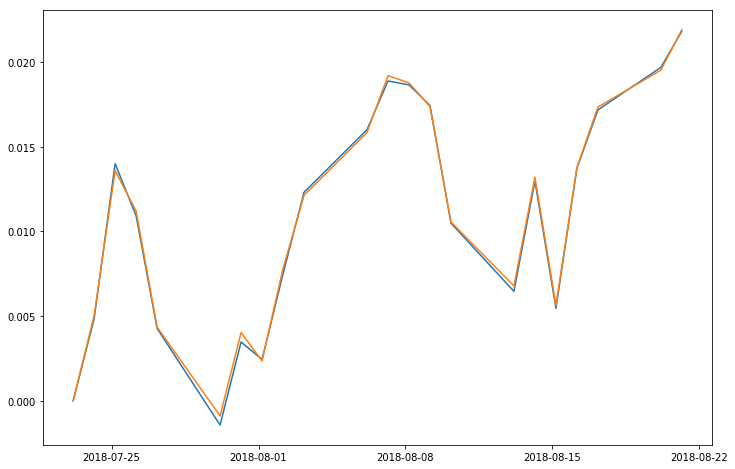

In [11]:
plt.figure(figsize=(12, 8))
plt.plot(performance)

# What if I have only 10K?

In [12]:
# This is to recalculate the weights at day 1 (instead of using the latest weights that are affected by the price changes)
mktvals = (closes.iloc[0] * constituent.loc['shares'])
weights = mktvals / mktvals.sum()

In [13]:
# Say I have $10K, how many shares would I have bought for each?
cash = 1e+4
new_shares = cash * weights // closes.iloc[0]
positions = pd.DataFrame({
    'shares': new_shares,
    'price': closes.iloc[0],
    'dollar': closes.iloc[0] * new_shares,
}).loc[new_shares > 0]
positions

,shares,price,dollar
AAPL,2,190.9403,381.881
MSFT,3,107.5560,322.668
FB,1,210.9100,210.91
JPM,1,113.3500,113.35
JNJ,1,126.6300,126.63
XOM,1,80.5690,80.569
BAC,3,30.7500,92.25
WFC,1,57.5786,57.5786
PFE,2,36.8958,73.7916
T,3,31.0000,93


In [14]:
positions.dollar.sum()

2085.6317999999997

In [15]:
new_perf = ((closes - closes.iloc[0]) * new_shares).sum(axis=1) / (closes.iloc[0] * new_shares).sum()

In [16]:
new_result = pd.DataFrame({
    'new_performance': new_perf,
    'original_performance': original_perf,
})

In [17]:
new_result

,new_performance,original_performance
epoch,,
2018-07-23 00:00:00-04:00,0.000000,0.000000
2018-07-24 00:00:00-04:00,0.008330,0.005032
2018-07-25 00:00:00-04:00,0.016651,0.013597
2018-07-26 00:00:00-04:00,-0.003846,0.011206
2018-07-27 00:00:00-04:00,-0.010809,0.004354
2018-07-30 00:00:00-04:00,-0.013892,-0.000892
2018-07-31 00:00:00-04:00,-0.011064,0.004033
2018-08-01 00:00:00-04:00,-0.000900,0.002355
2018-08-02 00:00:00-04:00,0.009131,0.007816


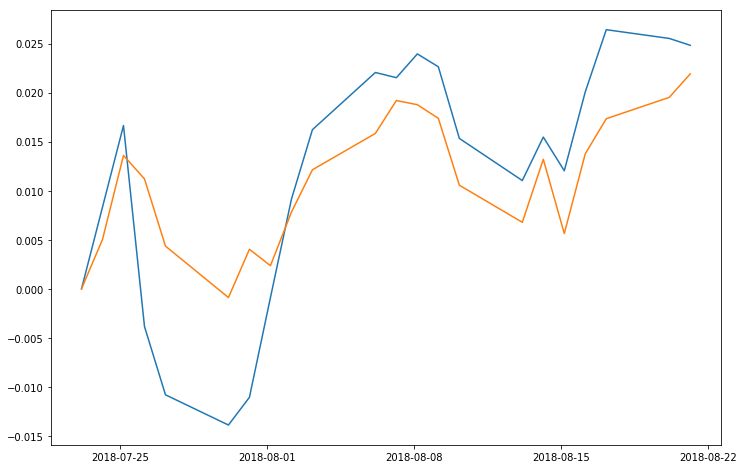

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(new_result)